## 0. Preparação

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
# from scipy.stats import boxcox
# from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from tqdm import tqdm
import warnings

warnings.simplefilter('ignore')

## 1. Exploração dos Dados

In [2]:
df = pd.read_csv("data_updated.csv")

df['week'] = pd.to_datetime(df['week'])
df = df.set_index('week').sort_index()

print("Estrutura dos Dados:")
print(df.info())
display(df.head())

Estrutura dos Dados:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 157 entries, 2022-10-31 to 2025-10-27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   volume  157 non-null    float64
 1   inv     157 non-null    float64
 2   users   157 non-null    float64
dtypes: float64(3)
memory usage: 4.9 KB
None


,volume,inv,users
week,,,
2022-10-31,0.38,1.609882,6.500
2022-11-07,0.47,1.880548,7.061
2022-11-14,0.32,2.297810,5.875
2022-11-21,1.69,5.623875,24.238
2022-11-28,1.23,1.473418,7.648


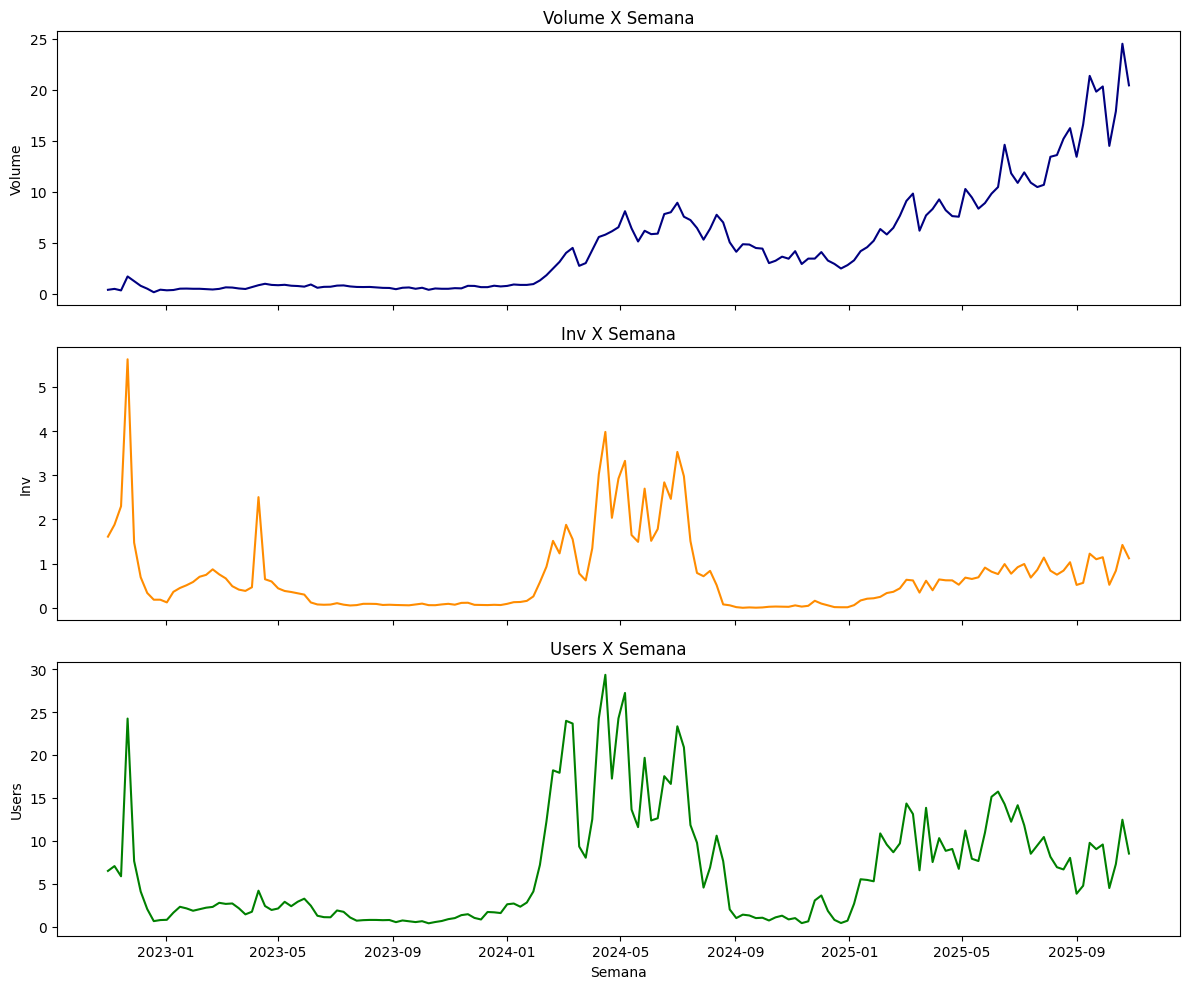

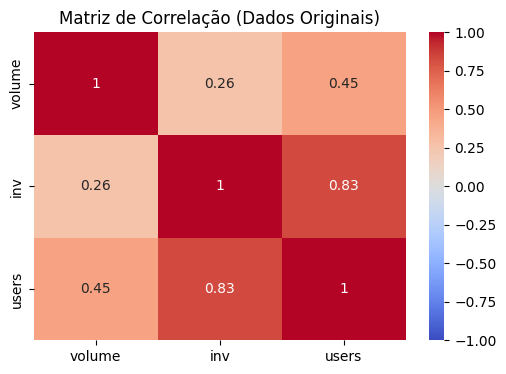

In [3]:
# 1. Visualização das Séries no Tempo
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12, 10))

axes[0].plot(df.index, df['volume'], color='navy')
axes[0].set_title('Volume X Semana')
axes[0].set_ylabel('Volume')
axes[0].grid(False)

axes[1].plot(df.index, df['inv'], color='darkorange')
axes[1].set_title('Inv X Semana')
axes[1].set_ylabel('Inv')
axes[1].grid(False)

axes[2].plot(df.index, df['users'], color='green')
axes[2].set_title('Users X Semana')
axes[2].set_ylabel('Users')
axes[2].set_xlabel('Semana')
axes[2].grid(False)

plt.tight_layout()
plt.show()

# 2. Matriz de Correlação
corr_matrix = df[['volume', 'inv', 'users']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação (Dados Originais)')
plt.show()


Como esperávamos, levando em conta o conhecimento do problema (users provavelmente é a quantidade de pessoas que compraram ou usaram um produto), o volume tem uma certa correlação com a variável users

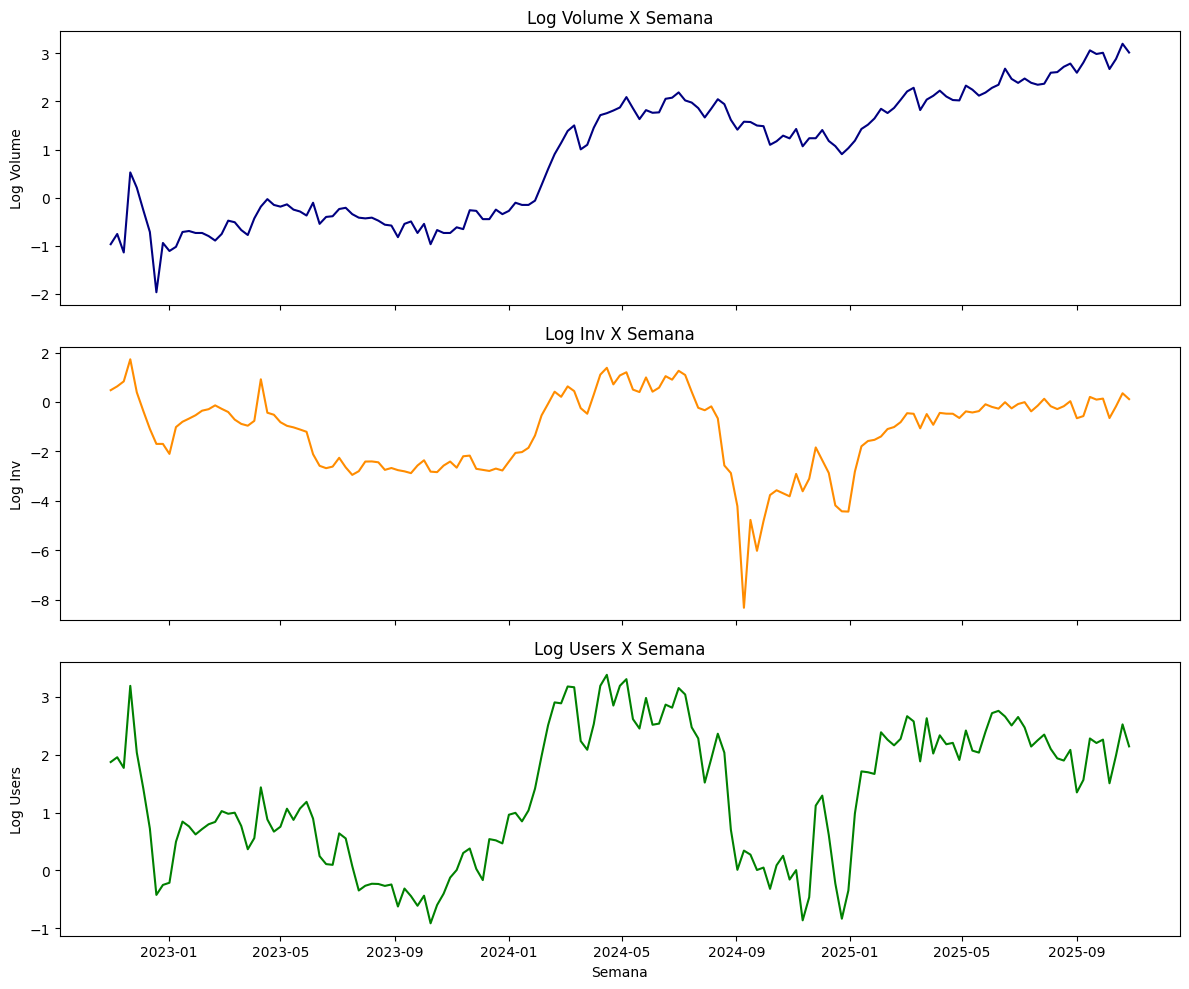

Correlação após Transformação Logarítmica:


,log_volume,log_inv,log_users
log_volume,1.000000,0.313855,0.674262
log_inv,0.313855,1.000000,0.806567
log_users,0.674262,0.806567,1.000000


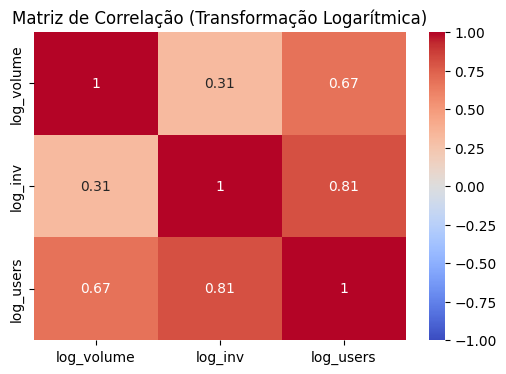

In [4]:
df['log_volume'] = np.log(df['volume'])
df['log_inv'] = np.log(df['inv'].replace(0, 0.001)) # Evitando log(0)
df['log_users'] = np.log(df['users'].replace(0, 0.001))

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12, 10))

axes[0].plot(df.index, df['log_volume'], color='navy')
axes[0].set_title('Log Volume X Semana')
axes[0].set_ylabel('Log Volume')
axes[0].grid(False)

axes[1].plot(df.index, df['log_inv'], color='darkorange')
axes[1].set_title('Log Inv X Semana')
axes[1].set_ylabel('Log Inv')
axes[1].grid(False)

axes[2].plot(df.index, df['log_users'], color='green')
axes[2].set_title('Log Users X Semana')
axes[2].set_ylabel('Log Users')
axes[2].set_xlabel('Semana')
axes[2].grid(False)

plt.tight_layout()
plt.show()

# Correlação após Log
# Às vezes a relação fica mais linear (melhor para SARIMAX/Regressão) no espaço Log
print("Correlação após Transformação Logarítmica:")
corr_matrix = df[['log_volume', 'log_inv', 'log_users']].corr()
display(corr_matrix)

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação (Transformação Logarítmica)')
plt.show()

A correlação linear entre as covariáveis e "volume" aumenta se aplicarmos log nelas, isso pode ser interessante para construir os modelos para ter melhores resultados. Vale observar, porém, que a correlação entre as variáveis `inv` e `users` é alta, o que pode ser prejudicial para alguns modelos, já que as informações de cada coluna serão quase colineares.

## 2. Diferenciação

In [5]:
# --- 1. Função Auxiliar para Teste ADF (Augmented Dickey-Fuller) ---
def verificar_estacionariedade(serie, nome_serie):
    """
    Executa o teste ADF.
    H0: A série NÃO é estacionária (possui raiz unitária).
    H1: A série É estacionária.
    Se p-valor < 0.05, rejeitamos H0 (é estacionária).
    """
    # Remove NaNs criados pelos diffs
    serie_limpa = serie.dropna()
    
    resultado = adfuller(serie_limpa)
    print(f'--- Teste ADF para: {nome_serie} ---')
    print(f'Estatística ADF: {resultado[0]:.4f}')
    print(f'P-valor: {resultado[1]:.4f}')
    
    if resultado[1] < 0.05:
        print("Resultado: ESTACIONÁRIA (Rejeita H0)\n")
    else:
        print("Resultado: NÃO ESTACIONÁRIA (Aceita H0)\n")

In [6]:
# --- 2. Preparação ---
# O Log estabiliza a variância (heterocedasticidade)
df['log_volume'] = np.log(df['volume'])
df['log_inv'] = np.log(df['inv'].replace(0, 0.001))
df['log_users'] = np.log(df['users'].replace(0, 0.001))

# Verificando a série com log
verificar_estacionariedade(df['log_volume'], 'Log Volume')

--- Teste ADF para: Log Volume ---
Estatística ADF: -1.1603
P-valor: 0.6904
Resultado: NÃO ESTACIONÁRIA (Aceita H0)



In [7]:
# --- Teste 1: Primeira Diferença (Remoção de Tendência) ---
# Fórmula: y_{t} - y_{t-1}
df['diff_1_volume'] = df['log_volume'].diff()

In [8]:
# --- Teste 2: Diferenciação Sazonal (Se houver ciclo anual) ---
# Como os dados são semanais, o período é 52 (1 ano). 
# Fator negativo: perde os primeiros 52 dados.
# Fórmula: y_{t} - y_{t-52}
df['diff_sazonal_volume'] = df['log_volume'].diff(52)

In [9]:
# Diferenciando Covariáveis (Para consistência do modelo) ---
df['diff_1_inv'] = df['log_inv'].diff()
df['diff_1_users'] = df['log_users'].diff()

In [10]:
# Teste 3: Diferença Combinada (1 e 52 semanas)
df['diff_combined_volume'] = df['log_volume'].diff(1).diff(52)

# Diferenciando Covariáveis (Para consistência do modelo) ---
df['diff_combined_inv'] = df['log_inv'].diff().diff(52)
df['diff_combined_users'] = df['log_users'].diff().diff(52)

In [11]:
verificar_estacionariedade(df['diff_1_volume'], 'Primeira Diferença')
verificar_estacionariedade(df['diff_sazonal_volume'], 'Diferença Sazonal')
verificar_estacionariedade(df['diff_combined_volume'], 'Diferença Combinada (1 e 52)')

--- Teste ADF para: Primeira Diferença ---
Estatística ADF: -5.9177
P-valor: 0.0000
Resultado: ESTACIONÁRIA (Rejeita H0)

--- Teste ADF para: Diferença Sazonal ---
Estatística ADF: -2.1894
P-valor: 0.2101
Resultado: NÃO ESTACIONÁRIA (Aceita H0)

--- Teste ADF para: Diferença Combinada (1 e 52) ---
Estatística ADF: -12.0638
P-valor: 0.0000
Resultado: ESTACIONÁRIA (Rejeita H0)



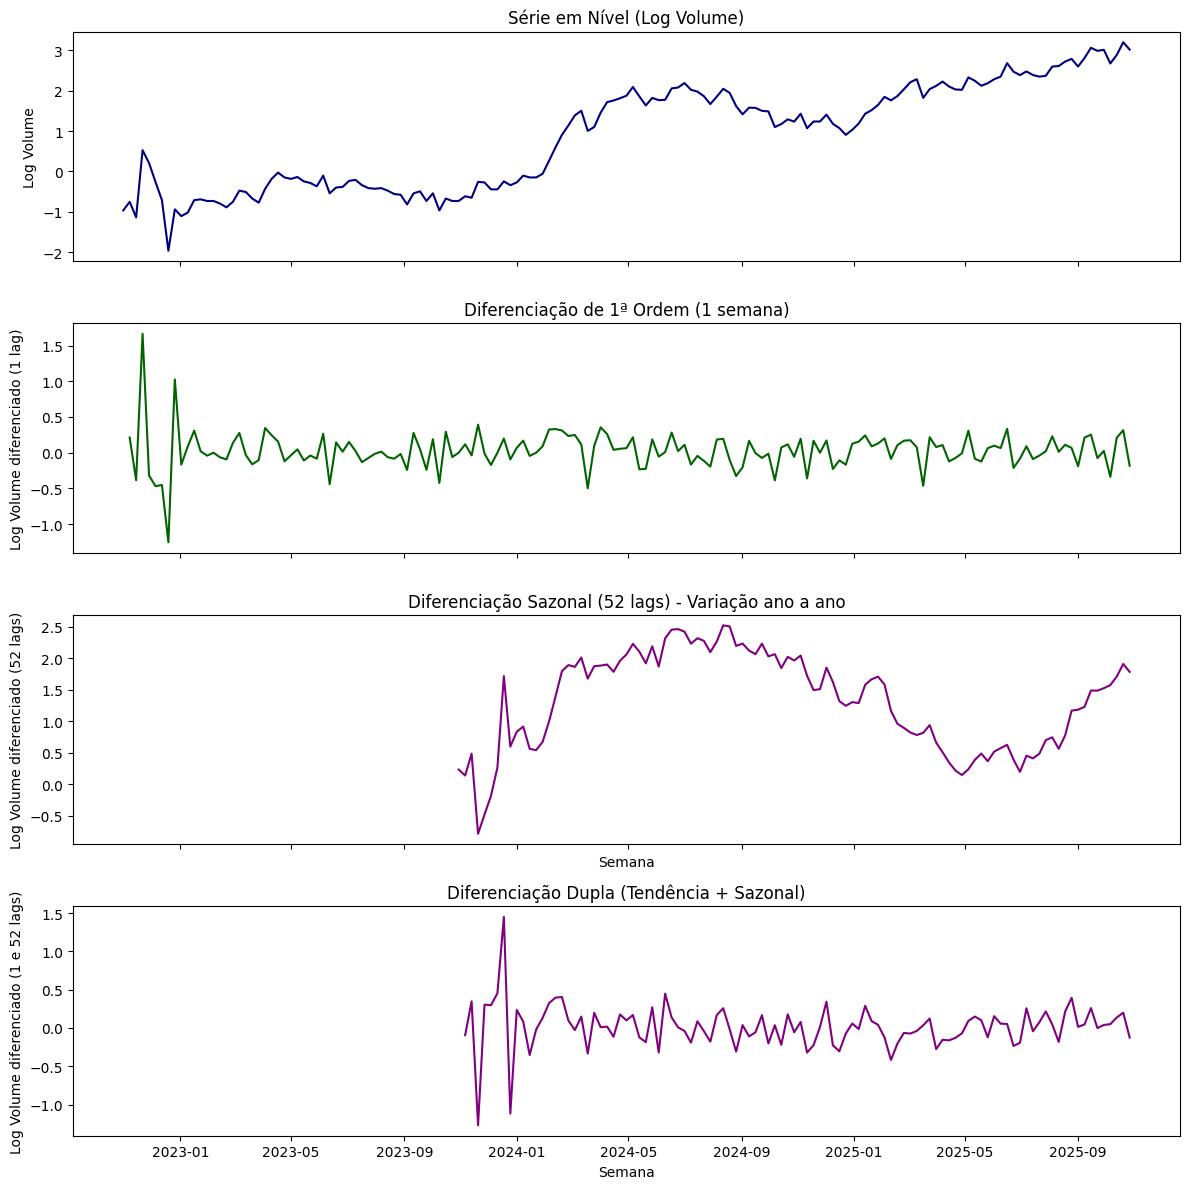

In [12]:
# --- Visualização e Verificação dos Resultados ---
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# Plot 1: Série Original (Log)
axes[0].plot(df.index, df['log_volume'], color='navy')
axes[0].set_title('Série em Nível (Log Volume)')
axes[0].set_ylabel('Log Volume')

# Plot 2: Primeira Diferença
axes[1].plot(df.index, df['diff_1_volume'], color='darkgreen')
axes[1].set_title('Diferenciação de 1ª Ordem (1 semana)')
axes[1].set_ylabel('Log Volume diferenciado (1 lag)')

# Plot 3: Diferenciação Sazonal (52 semanas)
axes[2].plot(df.index, df['diff_sazonal_volume'], color='purple')
axes[2].set_title('Diferenciação Sazonal (52 lags) - Variação ano a ano')
axes[2].set_ylabel('Log Volume diferenciado (52 lags)')
axes[2].set_xlabel('Semana')

# Plot 4: Diferenciação Combinada (1 e 52 semanas)
axes[3].plot(df.index, df['diff_combined_volume'], color='purple')
axes[3].set_title('Diferenciação Dupla (Tendência + Sazonal)')
axes[3].set_ylabel('Log Volume diferenciado (1 e 52 lags)')
axes[3].set_xlabel('Semana')

plt.tight_layout()
plt.show()

Correlação após Transformação Logarítmica + Diferença de 1ª Ordem:


,diff_1_volume,diff_1_inv,diff_1_users
diff_1_volume,1.000000,0.302200,0.670141
diff_1_inv,0.302200,1.000000,0.542892
diff_1_users,0.670141,0.542892,1.000000


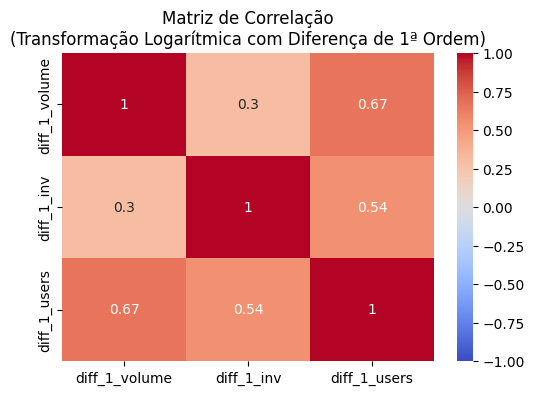

In [13]:
print("Correlação após Transformação Logarítmica + Diferença de 1ª Ordem:")
corr_matrix = df[['diff_1_volume', 'diff_1_inv', 'diff_1_users']].corr()
display(corr_matrix)

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação\n(Transformação Logarítmica com Diferença de 1ª Ordem)')
plt.show()

Correlação após Transformação Logarítmica + Diferença de tendência e sazonalidade:


,diff_combined_volume,diff_combined_inv,diff_combined_users
diff_combined_volume,1.000000,0.201914,0.597237
diff_combined_inv,0.201914,1.000000,0.409881
diff_combined_users,0.597237,0.409881,1.000000


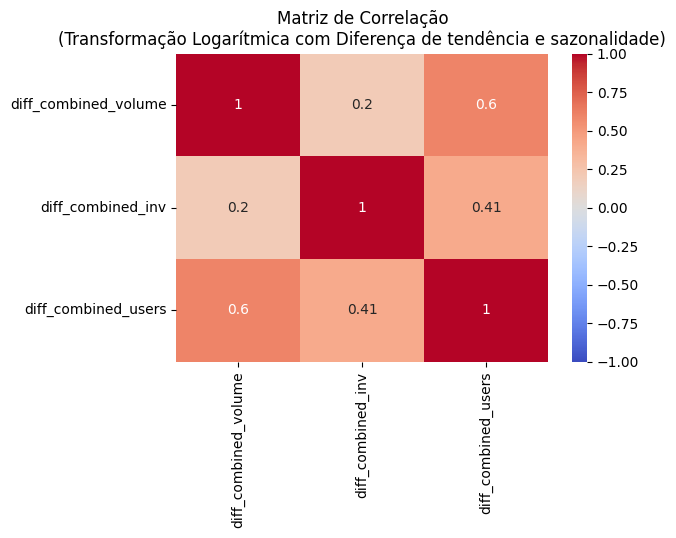

In [14]:
print("Correlação após Transformação Logarítmica + Diferença de tendência e sazonalidade:")
corr_matrix = df[['diff_combined_volume', 'diff_combined_inv', 'diff_combined_users']].corr()
display(corr_matrix)

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação\n(Transformação Logarítmica com Diferença de tendência e sazonalidade)')
plt.show()

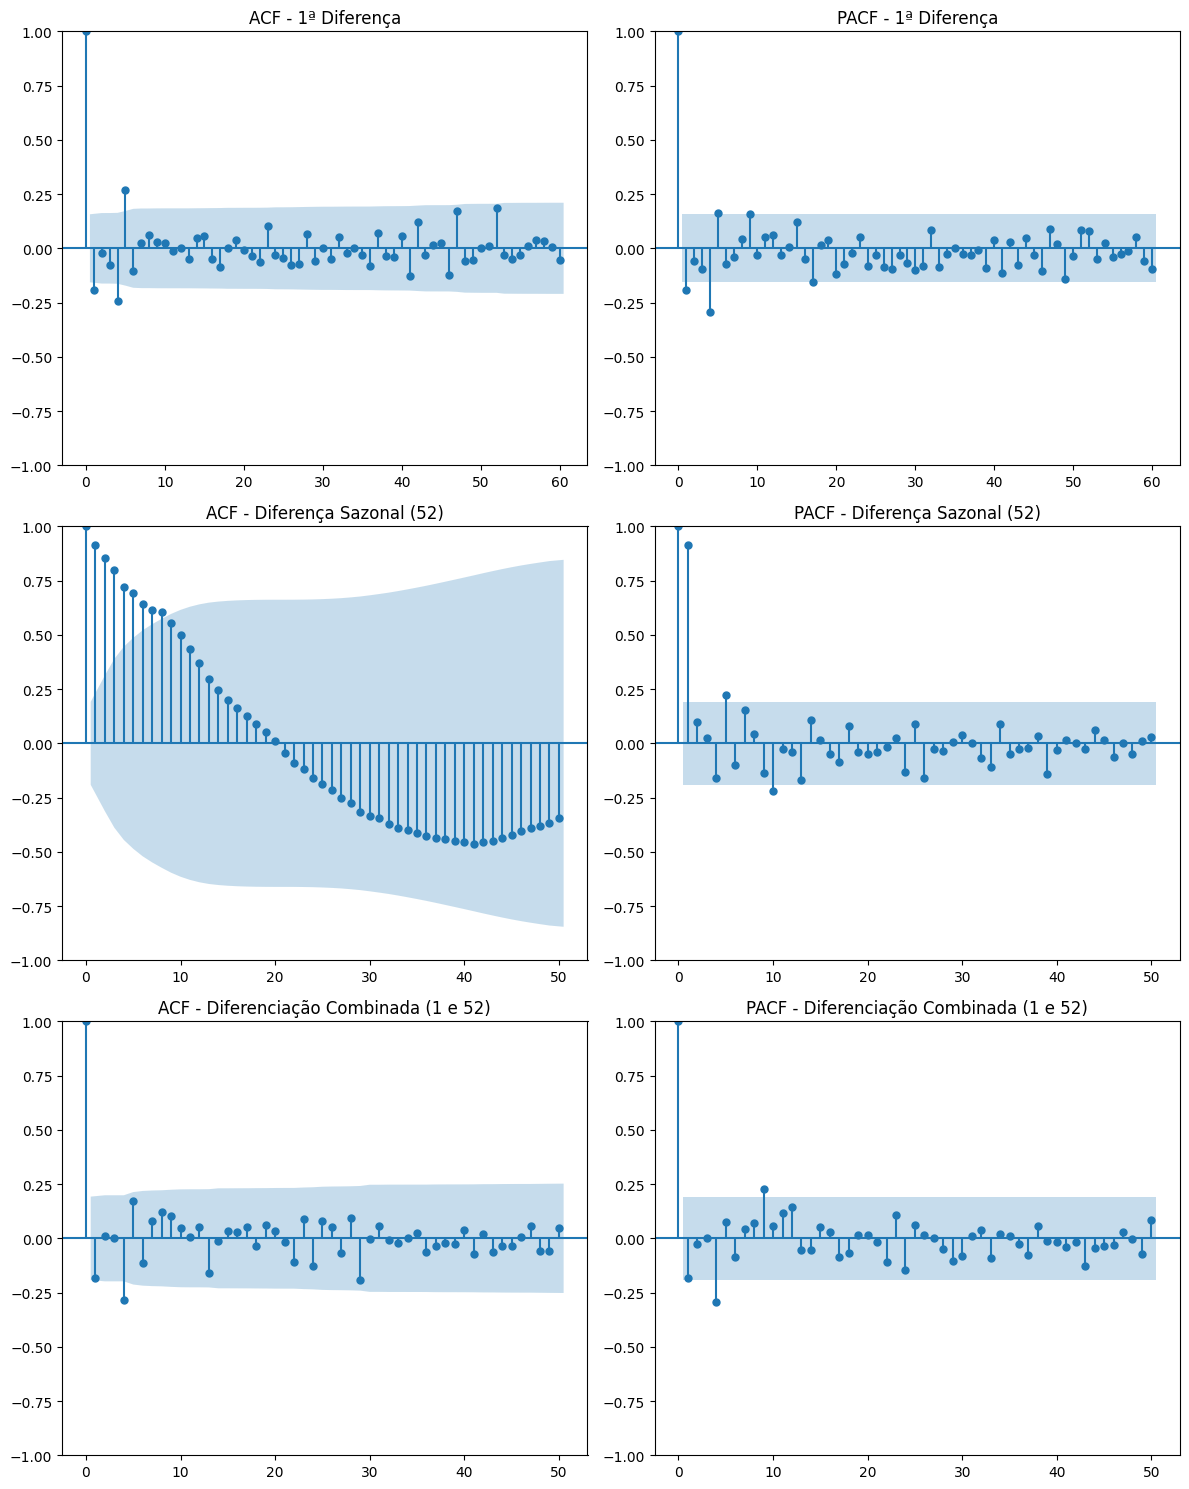

In [16]:
# Configurar o plot
fig, axes = plt.subplots(3, 2, figsize=(12, 15))

# ACF e PACF da Primeira Diferença
plot_acf(df['diff_1_volume'].dropna(), lags=60, ax=axes[0, 0], title='ACF - 1ª Diferença')
plot_pacf(df['diff_1_volume'].dropna(), lags=60, ax=axes[0, 1], title='PACF - 1ª Diferença')

# ACF e PACF da Diferença Sazonal (apenas para comparação)
plot_acf(df['diff_sazonal_volume'].dropna(), lags=50, ax=axes[1, 0], title='ACF - Diferença Sazonal (52)')
plot_pacf(df['diff_sazonal_volume'].dropna(), lags=50, ax=axes[1, 1], title='PACF - Diferença Sazonal (52)')

# ACF e PACF da Diferenciação Combinada (1 e 52 semanas)
plot_acf(df['diff_combined_volume'].dropna(), lags=50, ax=axes[2, 0], title='ACF - Diferenciação Combinada (1 e 52)')
plot_pacf(df['diff_combined_volume'].dropna(), lags=50, ax=axes[2, 1], title='PACF - Diferenciação Combinada (1 e 52)')

plt.tight_layout()
plt.show()

## 3. Funções Auxliares de Avaliação de Modelos

In [ ]:
def calculate_mase(y_true, y_pred, y_train, m=52):
    forecast_error = np.mean(np.abs(y_true - y_pred))
    naive_seasonal_errors = np.abs(y_train[m:] - y_train[:-m])
    mae_naive = np.mean(naive_seasonal_errors)

    if mae_naive == 0:
        return np.nan

    return forecast_error / mae_naive

def inverse_transform(y_log):
    return np.exp(y_log)

def walk_forward_validation(df, target_col, exog_cols, model_func,
                            initial_train_size=104, horizon=4, m=52, **model_params):
    results = []
    n_samples = len(df)
    for t in tqdm(range(initial_train_size, n_samples - horizon + 1)):
        train = df.iloc[:t]
        test = df.iloc[t : t + horizon]

        # Dados de treino na escala ORIGINAL para cálculo do MASE
        # Assumindo que o dataframe tem colunas originais 'volume' além das log
        train_original = np.exp(train[target_col])

        # 2. Treinamento e Previsão (Usando a função do modelo que passaremos depois)
        # A função deve retornar as previsões (yhat) na escala LOG
        yhat_log = model_func(train, test, target_col, exog_cols, horizon, **model_params)

        # 3. Re-escala para Original
        y_pred_original = inverse_transform(yhat_log)
        y_true_original = np.exp(test[target_col].values) # Target real das próximas h semanas

        # 4. Avaliação por horizonte (h=1, h=2, h=3, h=4)
        for h in range(horizon):
            # Pega o valor único para o horizonte h+1
            pred_h = y_pred_original[h]
            true_h = y_true_original[h]

            # Calcula erro pontual
            abs_error = np.abs(true_h - pred_h)
            sq_error = (true_h - pred_h) ** 2

            # Para o MASE, precisamos passar a série de treino inteira para calcular o denominador
            # Aqui calculamos o MASE pontual para esse horizonte específico
            mase_score = calculate_mase(np.array([true_h]), np.array([pred_h]), train_original.values, m)

            results.append({
                'cutoff_date': train.index[-1],
                'horizon': h + 1,
                'y_true': true_h,
                'y_pred': pred_h,
                'abs_error': abs_error,
                'sq_error': sq_error,
                'mase': mase_score
            })

    results_df = pd.DataFrame(results)
    metrics_per_h = results_df.groupby('horizon').agg({
        'abs_error': 'mean',   # MAE
        'sq_error': lambda x: np.sqrt(np.mean(x)), # RMSE
        'mase': 'mean'         # MASE Médio
    }).rename(columns={'abs_error': 'MAE', 'sq_error': 'RMSE', 'mase': 'MASE'})

    return metrics_per_h, results_df

## 4. Modelos

Escolhemos alguns modelos vistos em sala para explorá-los.

### ETS

In [ ]:
def holt_trend_func(train_df, test_df, target_col, exog_cols, horizon, **params):
    model = ExponentialSmoothing(
        train_df[target_col],
        trend='add',
        damped_trend=True,
        seasonal=None,
        initialization_method='estimated'
    )
    return model.fit(optimized=True).forecast(steps=horizon)

def holt_winters_func(train_df, test_df, target_col, exog_cols, horizon, **params):
    model = ExponentialSmoothing(
        train_df[target_col],
        trend='add',
        damped_trend=True,
        seasonal='add',
        seasonal_periods=52,
        initialization_method='estimated'
    )
    return model.fit(optimized=True).forecast(steps=horizon)

def calculate_internal_metrics(df, target_col, initial_train_size):
    train_data = df[target_col].iloc[:initial_train_size]
    metrics = []
    models = [
        ('Holt (Trend Only)', {'trend': 'add', 'seasonal': None, 'damped': True}),
        ('Holt-Winters (Seasonal)', {'trend': 'add', 'seasonal': 'add', 'damped': True})
    ]

    print(f">>> Calculando AIC/BIC (Treino: {len(train_data)} semanas)...")
    for name, params in models:
        m = ExponentialSmoothing(
            train_data,
            trend=params['trend'],
            damped_trend=params['damped'],
            seasonal=params['seasonal'],
            seasonal_periods=52 if params['seasonal'] else None,
            initialization_method='estimated'
        )
        fit = m.fit(optimized=True)
        metrics.append({'Modelo': name, 'AICc': fit.aicc, 'BIC': fit.bic})
    return pd.DataFrame(metrics).set_index('Modelo')


In [ ]:
TARGET = 'log_volume'
HORIZON = 4
INITIAL_TRAIN = 104 # ~2 anos
M = 52


df_internal = calculate_internal_metrics(df, TARGET, INITIAL_TRAIN)

# B. Walk-Forward (Métricas Externas)
print(">>> Rodando Walk-Forward: Holt (Trend Only)...")
metrics_holt, _ = walk_forward_validation(df, TARGET, [], holt_trend_func, INITIAL_TRAIN, HORIZON, M)

print(">>> Rodando Walk-Forward: Holt-Winters (Seasonal)...")
metrics_hw, _ = walk_forward_validation(df, TARGET, [], holt_winters_func, INITIAL_TRAIN, HORIZON, M)

# C. Construção da Tabela Detalhada por 'h'
summary_data = {
    'AICc': df_internal['AICc'],
    'BIC': df_internal['BIC']
}

# Adiciona colunas para cada horizonte (MASE e RMSE)
for h in range(1, HORIZON + 1):
    summary_data[f'MASE (h={h})'] = [
        metrics_holt.loc[h, 'MASE'],
        metrics_hw.loc[h, 'MASE']
    ]

# Adiciona RMSE apenas do h=4 para não poluir demais (ou descomente o loop abaixo para todos)
summary_data[f'RMSE (h={HORIZON})'] = [
    metrics_holt.loc[HORIZON, 'RMSE'],
    metrics_hw.loc[HORIZON, 'RMSE']
]

summary_df = pd.DataFrame(summary_data, index=['Holt (Trend Only)', 'Holt-Winters (Seasonal)'])

def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: #d6f5d6; color: black; font-weight: bold' if v else '' for v in is_min]

# Formatação para facilitar leitura
format_dict = {'AICc': '{:.1f}', 'BIC': '{:.1f}'}
for col in summary_df.columns:
    if 'MASE' in col or 'RMSE' in col:
        format_dict[col] = '{:.4f}'

display(summary_df.style.apply(highlight_min).format(format_dict))


### Arima

In [ ]:
def sarimax_model_func(train_df, test_df, target_col, exog_cols, horizon, **params):
    y_train = train_df[target_col]
    X_train = train_df[exog_cols]
    X_test = test_df[exog_cols] # Exógenas futuras (reais no teste)
    model = pm.auto_arima(
        y_train,
        X=X_train,
        start_p=1, start_q=1,
        max_p=2, max_q=2, # Limitando para evitar explosão combinatória
        m=52,             # Sazonalidade anual
        seasonal=True,    # Ativa componente sazonal (P,D,Q)
        d=None,           # Deixa o teste (KPSS) decidir a diferenciação
        test='kpss',
        information_criterion='aicc', # SELEÇÃO VIA AICc
        trace=False,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True     # Otimização rápida (não testa todas as combinações possíveis)
    )

    forecast = model.predict(n_periods=horizon, X=X_test)
    return forecast

In [ ]:
EXOG_SARIMAX = ['log_inv', 'log_users']
metrics_sarimax, _ = walk_forward_validation(
    df,
    TARGET,
    EXOG_SARIMAX, # Aqui passamos as exógenas!
    sarimax_model_func,
    INITIAL_TRAIN,
    HORIZON,
    M
)

final_comparison = pd.DataFrame({
    'MASE (h=1)': [metrics_holt.loc[1, 'MASE'], metrics_sarimax.loc[1, 'MASE']],
    'MASE (h=4)': [metrics_holt.loc[4, 'MASE'], metrics_sarimax.loc[4, 'MASE']],
    'RMSE (h=4)': [metrics_holt.loc[4, 'RMSE'], metrics_sarimax.loc[4, 'RMSE']]
}, index=['ETS (Holt Trend)', 'SARIMAX (Exog)'])

def highlight_winner(s):
    is_min = s == s.min()
    return ['background-color: #d6f5d6; font-weight: bold' if v else '' for v in is_min]

display(final_comparison.style.apply(highlight_winner).format("{:.4f}"))

In [ ]:
EXOG_SARIMAX = ['log_users']
metrics_sarimax, _ = walk_forward_validation(
    df,
    TARGET,
    EXOG_SARIMAX, # Aqui passamos as exógenas!
    sarimax_model_func,
    INITIAL_TRAIN,
    HORIZON,
    M
)

final_comparison = pd.DataFrame({
    'MASE (h=1)': [metrics_holt.loc[1, 'MASE'], metrics_sarimax.loc[1, 'MASE']],
    'MASE (h=4)': [metrics_holt.loc[4, 'MASE'], metrics_sarimax.loc[4, 'MASE']],
    'RMSE (h=4)': [metrics_holt.loc[4, 'RMSE'], metrics_sarimax.loc[4, 'RMSE']]
}, index=['ETS (Holt Trend)', 'SARIMAX (Exog)'])

def highlight_winner(s):
    is_min = s == s.min()
    return ['background-color: #d6f5d6; font-weight: bold' if v else '' for v in is_min]

display(final_comparison.style.apply(highlight_winner).format("{:.4f}"))